In [ ]:
import os
import pandas as pd

In [ ]:
df = pd.read_csv('data.csv', sep=";")
df

## LLMChain

This is the most basic chain. It is the atomic building block for all other chains.

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [ ]:
llm_model = "gpt-3.5-turbo"

In [ ]:
llm = ChatOpenAI(temperature=0.9)

In [ ]:
prompt = ChatPromptTemplate.from_template("What is the best name to describe a company that makes {product}")

In [ ]:
chain = LLMChain(llm=llm, prompt=prompt, verbose=True)

In [ ]:
product = "Beer-can-holders for bikes"

In [ ]:
chain.run(product)

## SimpleSequentialChain

The Simple Sequential Chain pipes the output of one LLMChain to the next LLMChain

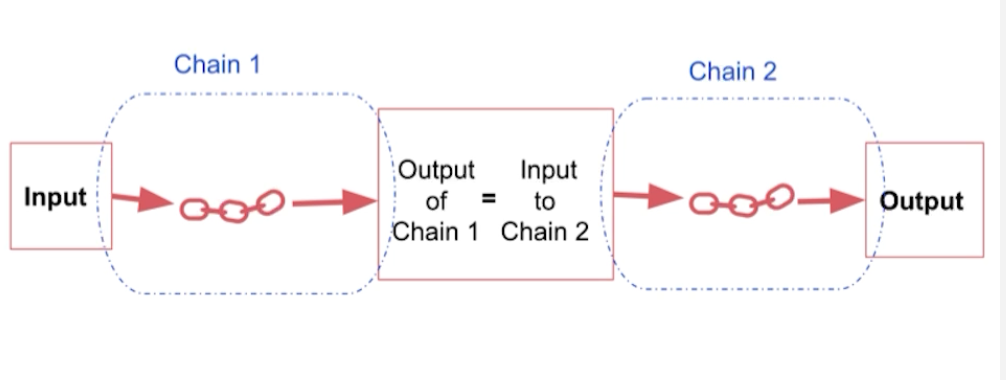

In [ ]:
from langchain.chains import SimpleSequentialChain

In [ ]:
# Take prompt from above
first_prompt = prompt
first_prompt

In [ ]:
chain_one = LLMChain(llm=llm, prompt=first_prompt, verbose=True)

In [ ]:
second_prompt = ChatPromptTemplate.from_template("Write a 20 words description for the following company: {company_name}")

In [ ]:
chain_two = LLMChain(llm=llm, prompt=second_prompt, verbose=True)

In [ ]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two], verbose=True)

In [ ]:
overall_simple_chain.run(product)

## Sequential Chain

The SequentialChain can combine multiple outputs from multiple chains. Think of it as SimpleSequentialChains running in parallel.

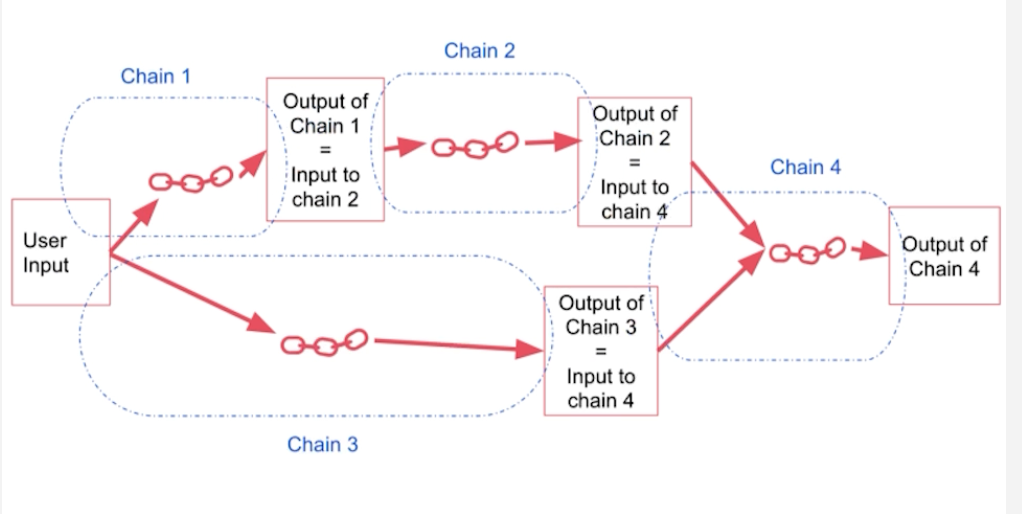

In [ ]:
from langchain.chains import SequentialChain
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [ ]:
# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to German:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="German_Review"
                    )


In [ ]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{German_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [ ]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [ ]:
# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [ ]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["German_Review", "summary","followup_message"],
    verbose=True
)

In [ ]:
overall_chain(df.Review[3])

## Router Chain

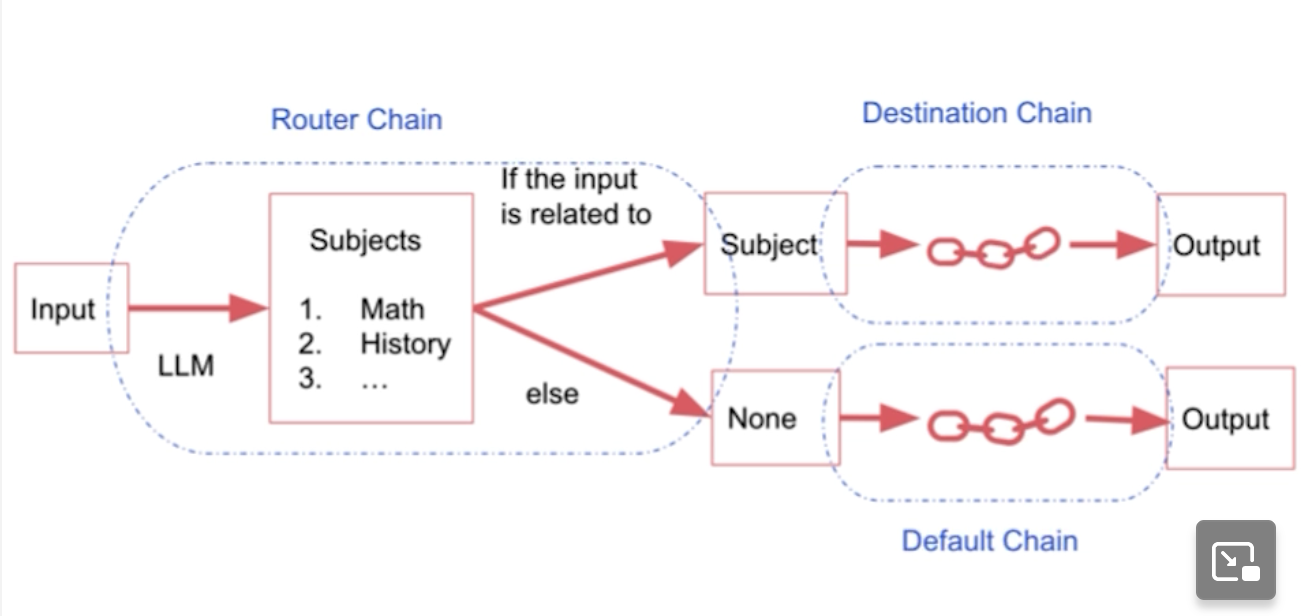

In [ ]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [ ]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [ ]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [ ]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [ ]:
# Creates empty dictionary
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"] # retrieves name, needed as key for dictionary
    prompt_template = p_info["prompt_template"] # retrieves prompt_template, needed in next step
    prompt = ChatPromptTemplate.from_template(template=prompt_template) # create ChatPromptTemplate which goes into the dictionary as value
    chain = LLMChain(llm=llm, prompt=prompt) # create the LLMChain from the values extracted or created
    destination_chains[name] = chain #write the key - value pair for the dictionary

In [ ]:
# List comprehension to create list of destinations
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]

# Turn this into string to include in router prompt.
destinations_str = "\n".join(destinations)

In [ ]:
# Default prompt is just the input
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [ ]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [ ]:
# Format router template from above

router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)

# Create router prompt from template
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

# Now create router chain
router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [ ]:
# Initialize overall system
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [ ]:
chain.run("Why did Beethoven die?")